<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#-Data-Prep" data-toc-modified-id="-Data-Prep-1"> Data Prep</a></span></li></ul></div>

In [49]:
import sys
sys.path.append('../')
import os
from clean_text import normalize_text
from tqdm import tqdm
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud

In [2]:
working_dir = os.getcwd()
data_path = os.path.dirname(working_dir) + '/data/'
print(data_path)

/Users/WillemCole/Desktop/DataScience/Projects/sf_building_complaints/data/


In [3]:
df = pd.read_csv(data_path + 'complaints.csv')

/Users/WillemCole/miniconda3/envs/sf_building_complaints/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


When we read the csv file we notice a DtypeWarning about mixed types in our complaint_number column which should be the index. We will fix this shortly.

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
df.head()

,complaint_number,date_filed,date_abated,block,lot,street_number,street_name,street_suffix,unit,zip_code,complaint_description,status,receiving_division,assigned_division,last_inspection_date,date_1st_nov_issued,nov_type,date_2nd_nov_issued,closed_date,director_hearing_date,final_warning_letter_issued,parcel_number,analysis_neighborhood,supervisor_district,point,:@computed_region_6qbp_sg9q,:@computed_region_qgnn_b9vv,:@computed_region_26cr_cadq,:@computed_region_ajp5_b2md,:@computed_region_rxqg_mtj9,:@computed_region_yftq_j783,:@computed_region_jx4q_fizf,:@computed_region_bh8s_q3mv,:@computed_region_jwn9_ihcz,date_referred_to_city_attorney
0,H9504209,1995-12-05T00:00:00.000,1995-12-06T00:00:00.000,0822,029,969,Hayes,St,2.0,94117.0,Illegal unit in back.,Not Active,Housing Inspection Services,Building Inspection Division,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H9601135,1996-03-12T00:00:00.000,1996-03-19T00:00:00.000,1364,003,121,4th,Av,NaN,94118.0,Illegal demolition,Not Active,Housing Inspection Services,Building Inspection Division,1996-03-15T00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H9403757,1994-10-21T00:00:00.000,1994-10-31T00:00:00.000,6652,023,1731,Noe,St,NaN,94131.0,No heat since 25th of august/.,Not Active,Housing Inspection Services,Housing Inspection Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,199600880,1996-09-03T00:00:00.000,1996-09-03T00:00:00.000,2699,041,315,Douglass,St,NaN,94114.0,Routine inspection,Not Active,Housing Inspection Services,Housing Inspection Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,199602151,1996-11-12T00:00:00.000,1997-01-31T00:00:00.000,0606,017,2400,Steiner,St,NaN,94115.0,Routine inspection,Not Active,Housing Inspection Services,Housing Inspection Services,1996-11-12T00:00:00.000,1996-11-12T00:00:00.000,Routine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#view the shape of our dataset
df.shape

(267467, 35)

In [7]:
#view a sample of 10 complaint_numbers where the complaint contains a character instead of digit
#this will help us understand why pandas couldn't parse this column as the index which was done in our fetch_data file
df.loc[~df['complaint_number'].astype(str).str.isdigit(), 'complaint_number'].sample(10)

8907     H9603096
2889     H9601863
2270     H9501969
2299     H9603343
9965     H9503964
8407     H9602337
8535     H9500706
3197     H9404285
10179    H9401840
4743     H9403625
Name: complaint_number, dtype: object

In [8]:
#replace the H's that occur in the complaint_number with ''
df['complaint_number'] = pd.to_numeric(df['complaint_number'].replace('H','', regex = True))
#set the index to the new complaint_number
df.set_index('complaint_number', inplace = True)

In [9]:
#check for duplicate rows
df.duplicated().sum()

460

In [10]:
#check data types
df.dtypes

date_filed                         object
date_abated                        object
block                              object
lot                                object
street_number                       int64
street_name                        object
street_suffix                      object
unit                              float64
zip_code                          float64
complaint_description              object
status                             object
receiving_division                 object
assigned_division                  object
last_inspection_date               object
date_1st_nov_issued                object
nov_type                           object
date_2nd_nov_issued                object
closed_date                        object
director_hearing_date              object
final_warning_letter_issued        object
parcel_number                      object
analysis_neighborhood              object
supervisor_district               float64
point                             

In [11]:
#examine a sample of complaint descriptions
display(df.complaint_description.sample(10))

complaint_number
200120639    Too many tenants in a room(11 in one room)duri...
199919969    Broken window in bedroom owner refuses to repa...
202015041    2522 38th ave --- an inspector needs to be sen...
201148626    Removed kitchen and bath without permit. remov...
201277405    Date last observed: 15-nov-12;    time last ob...
201990805            Failure to comply with sof story tier iii
200717673    Possible illegal unit at  lower level of singl...
201793911    26 beverly --- they are doing driveway and sid...
200453912                                              Routine
200796655                                         Broken sewer
Name: complaint_description, dtype: object

In [12]:
#determine where null values are located
df.isna().sum()

date_filed                             0
date_abated                        76026
block                                  0
lot                                    0
street_number                          0
street_name                            0
street_suffix                          0
unit                              232318
zip_code                            1076
complaint_description                432
status                                 0
receiving_division                     0
assigned_division                      8
last_inspection_date              134345
date_1st_nov_issued               157959
nov_type                          173684
date_2nd_nov_issued               256858
closed_date                       197523
director_hearing_date             252512
final_warning_letter_issued       248762
parcel_number                       3719
analysis_neighborhood               3715
supervisor_district                 3715
point                               3704
:@computed_regio

In [13]:
#drop the columns that have null complaint descriptions
df.dropna(subset = ['complaint_description'], inplace = True)

In [14]:
#group the most common 20 complaint descriptions
common_complaints = df.complaint_description.value_counts().sort_values(ascending = False).head(20)

print(common_complaints)

Routine inspection                                                       19466
Routine                                                                  12653
Routine safety inspection                                                 4664
Routine inspection.                                                       1584
Routines.                                                                 1519
Vacant storefront                                                         1506
Routines                                                                  1317
Vacant building                                                           1176
No heat                                                                   1023
Unsafe bldg.                                                               963
Routine inspection of common areas of subject property.                    924
Routine apartment house inspection                                         882
Health and safety inspection of apartment house. sec

In [15]:
# create a dataset sorted by common complaint description 
#note we multiply the size of each group by -1 to sort in descending order
#ascending = False doesn't work with argsort
sorted_complaints = df.iloc[df.groupby('complaint_description').complaint_description.transform('size') \
          .mul(-1).argsort(kind='mergesort')].head(common_complaints.sum())

In [16]:
#here we can view the most common complaint descriptions
#we see that the majority of the "routine" complaints are assigned to Housing Inspection Services
complaints_by_division = sorted_complaints.groupby(['assigned_division']) \
                    ['complaint_description'].value_counts() \
                    .sort_values(ascending = False).to_frame() \
                    .rename(columns={'complaint_description':'complaint_count'}).reset_index()

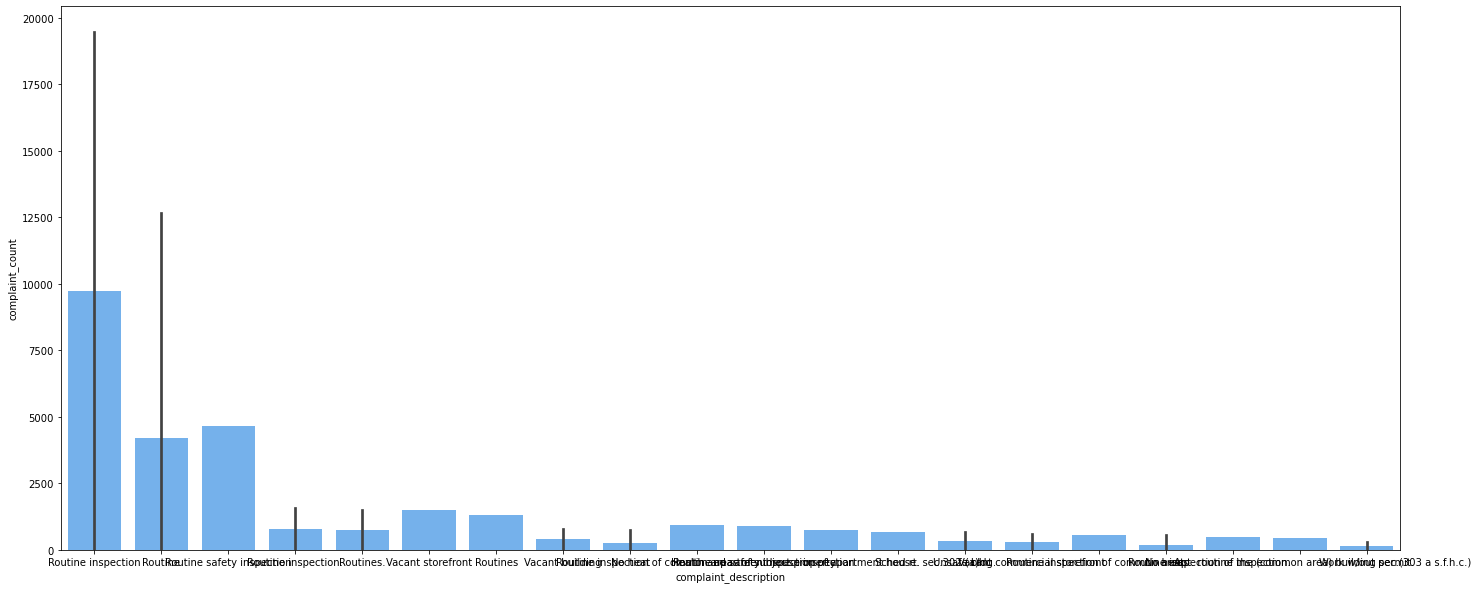

In [17]:
fig, ax = plt.subplots(figsize=(24,10))

ax = sns.barplot(x=complaints_by_division['complaint_description'], 
                 y=complaints_by_division['complaint_count'], color='dodgerblue', 
                 alpha = .7)

In [18]:
#create a df of complaints that were reassigned from their original location
reassigned = df.loc[(df['receiving_division'] != df['assigned_division'])]

In [19]:
common_reassigned = reassigned.complaint_description.value_counts().sort_values(ascending = False).head(20)

In [20]:
sorted_reassigned = reassigned.iloc[reassigned.groupby('complaint_description').complaint_description.transform('size') \
          .mul(-1).argsort(kind='mergesort')].head(common_reassigned.sum())

In [21]:
reassigned_by_division = sorted_reassigned.groupby(['assigned_division']) \
                    ['complaint_description'].value_counts() \
                    .sort_values(ascending = False).to_frame() \
                    .rename(columns={'complaint_description':'complaint_count'}).reset_index()  

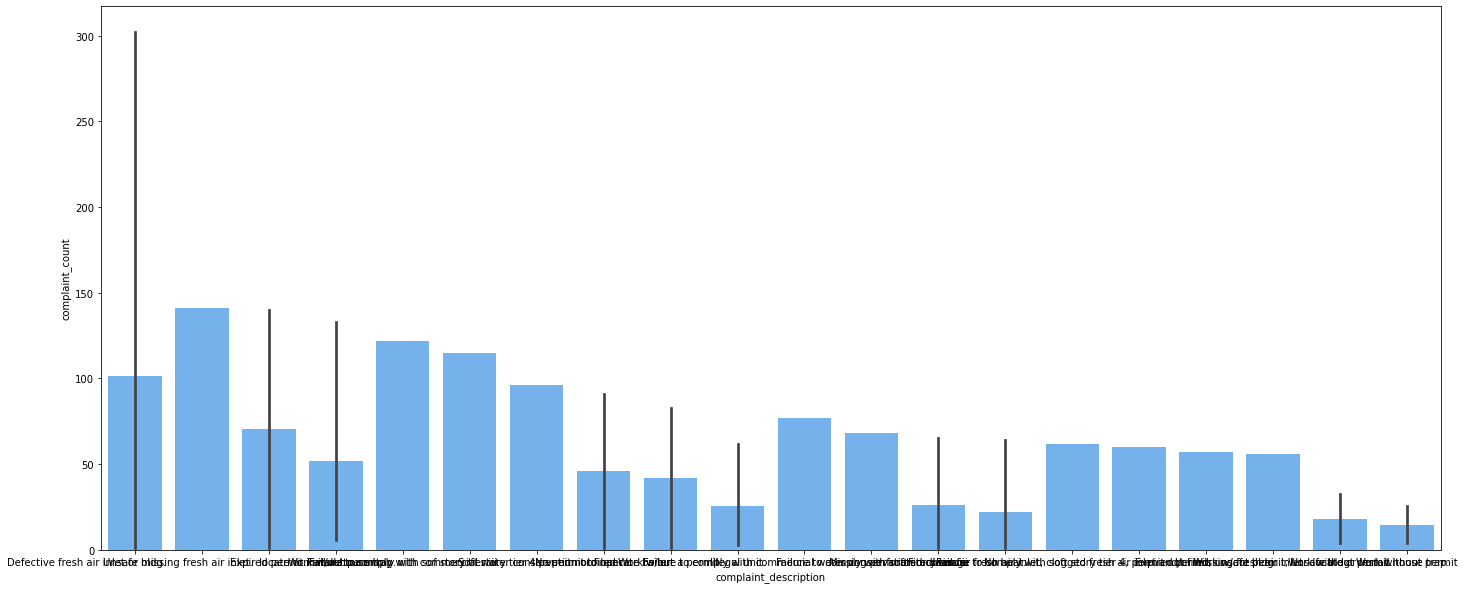

In [22]:
#we can see that complaints that were reassigned have a much larger dispersion
fig, ax = plt.subplots(figsize=(24,10))

ax = sns.barplot(x=reassigned_by_division['complaint_description'], 
                 y=reassigned_by_division['complaint_count'], color='dodgerblue', 
                 alpha = .7)

Finally we will look at our complaints in further detail 

Mean complaint length:  110.22917220589062
Min complaint length:  1
Max complaint length:  1000


Text(0, 0.5, 'Count')

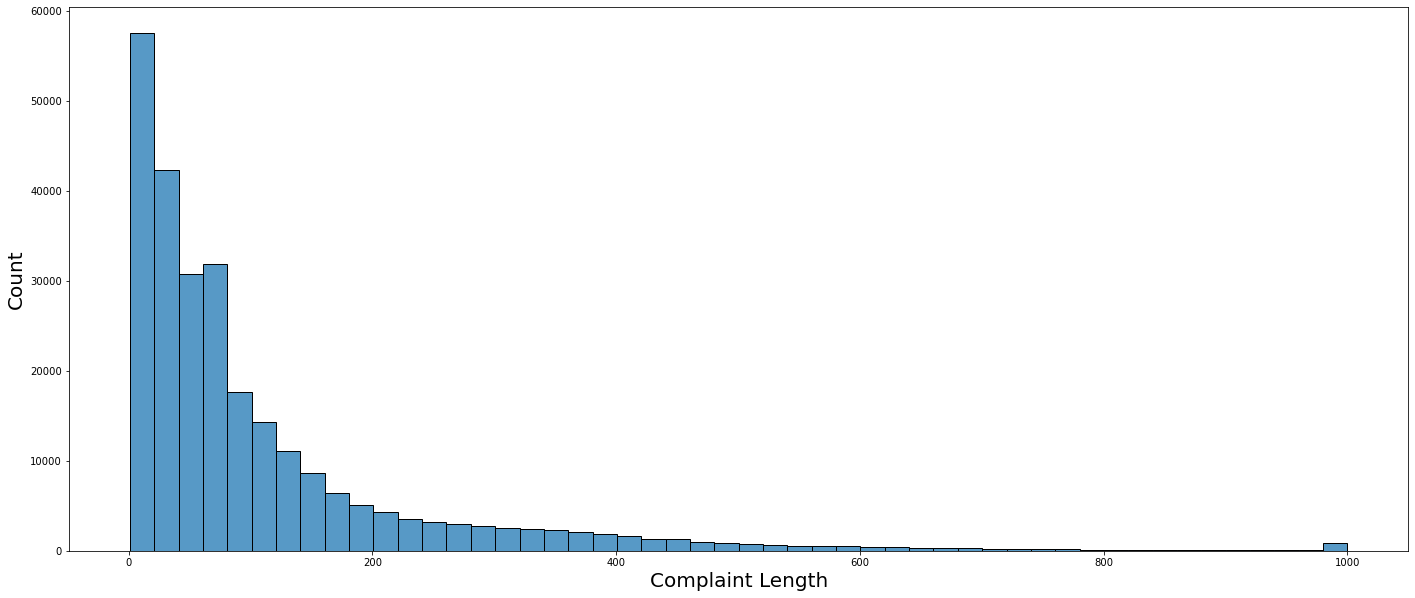

In [23]:
df['complaint_length'] = df['complaint_description'].apply(len)
print("Mean complaint length: ", df['complaint_length'].mean())
print("Min complaint length: ", df['complaint_length'].min())
print("Max complaint length: ", df['complaint_length'].max())

#plot a histogram of the complaint lengths
fig, ax = plt.subplots(figsize=(24,10))
ax = sns.histplot(data = df, x='complaint_length', bins = 50)
ax.set_xlabel('Complaint Length', fontsize = 20)
ax.set_ylabel('Count', fontsize = 20)

In [24]:
# text = list(df['complaint_description'].values)
# stop_words = set(stopwords.words('english'))

# wordcloud = WordCloud(stopwords=STOPWORDS).generate(str(text))
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

<h1> Data Prep</h1>

At this point we will drop unncessary columns and begin to transform the complaints 


In [25]:
df["complaint_description"].str.len().max()

1000

In [26]:
complaints = df.copy()

In [27]:
complaints.head()

,date_filed,date_abated,block,lot,street_number,street_name,street_suffix,unit,zip_code,complaint_description,status,receiving_division,assigned_division,last_inspection_date,date_1st_nov_issued,nov_type,date_2nd_nov_issued,closed_date,director_hearing_date,final_warning_letter_issued,parcel_number,analysis_neighborhood,supervisor_district,point,:@computed_region_6qbp_sg9q,:@computed_region_qgnn_b9vv,:@computed_region_26cr_cadq,:@computed_region_ajp5_b2md,:@computed_region_rxqg_mtj9,:@computed_region_yftq_j783,:@computed_region_jx4q_fizf,:@computed_region_bh8s_q3mv,:@computed_region_jwn9_ihcz,date_referred_to_city_attorney,complaint_length
complaint_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9504209,1995-12-05T00:00:00.000,1995-12-06T00:00:00.000,0822,029,969,Hayes,St,2.0,94117.0,Illegal unit in back.,Not Active,Housing Inspection Services,Building Inspection Division,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
9601135,1996-03-12T00:00:00.000,1996-03-19T00:00:00.000,1364,003,121,4th,Av,NaN,94118.0,Illegal demolition,Not Active,Housing Inspection Services,Building Inspection Division,1996-03-15T00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
9403757,1994-10-21T00:00:00.000,1994-10-31T00:00:00.000,6652,023,1731,Noe,St,NaN,94131.0,No heat since 25th of august/.,Not Active,Housing Inspection Services,Housing Inspection Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30
199600880,1996-09-03T00:00:00.000,1996-09-03T00:00:00.000,2699,041,315,Douglass,St,NaN,94114.0,Routine inspection,Not Active,Housing Inspection Services,Housing Inspection Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
199602151,1996-11-12T00:00:00.000,1997-01-31T00:00:00.000,0606,017,2400,Steiner,St,NaN,94115.0,Routine inspection,Not Active,Housing Inspection Services,Housing Inspection Services,1996-11-12T00:00:00.000,1996-11-12T00:00:00.000,Routine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18


In [28]:
#we only need the complaint number, description, and dvision it was assigned to for our model
final_cols = ['complaint_number','complaint_description', 'assigned_division']
complaints.drop(columns = complaints.columns.difference(final_cols), inplace=True)

In [29]:
complaints.head()

,complaint_description,assigned_division
complaint_number,,
9504209,Illegal unit in back.,Building Inspection Division
9601135,Illegal demolition,Building Inspection Division
9403757,No heat since 25th of august/.,Housing Inspection Services
199600880,Routine inspection,Housing Inspection Services
199602151,Routine inspection,Housing Inspection Services


In [30]:
complaints.complaint_description.isna().sum()

0

In [31]:
sample = complaints.copy()

In [37]:
#create lemmatized text
tqdm.pandas()
lemmatized = sample.copy()
lemmatized['complaint_description'] = lemmatized['complaint_description'].progress_apply(lambda x: normalize_text(x, lemmatize = True))
lemmatized.to_csv(data_path + '/lemmatized_text.csv')

  0%|          | 0/267035 [00:00<?, ?it/s]

In [33]:
sample.head()

,complaint_description,assigned_division
complaint_number,,
9504209,Illegal unit in back.,Building Inspection Division
9601135,Illegal demolition,Building Inspection Division
9403757,No heat since 25th of august/.,Housing Inspection Services
199600880,Routine inspection,Housing Inspection Services
199602151,Routine inspection,Housing Inspection Services


In [35]:
#create stemmed text
tqdm.pandas()
stemmed = sample.copy()
stemmed['complaint_description'] = stemmed['complaint_description'].progress_apply(lambda x: normalize_text(x))
stemmed.to_csv(data_path + '/stemmed_text.csv')

  0%|          | 0/267035 [00:00<?, ?it/s]

In [45]:
complaints.head()

,complaint_description,assigned_division
complaint_number,,
9504209,Illegal unit in back.,Building Inspection Division
9601135,Illegal demolition,Building Inspection Division
9403757,No heat since 25th of august/.,Housing Inspection Services
199600880,Routine inspection,Housing Inspection Services
199602151,Routine inspection,Housing Inspection Services


In [47]:
stemmed.head()

,complaint_description,assigned_division
complaint_number,,
9504209,"[illeg, unit, back]",Building Inspection Division
9601135,"[illeg, demolit]",Building Inspection Division
9403757,"[heat, sinc, th, august]",Housing Inspection Services
199600880,"[routin, inspect]",Housing Inspection Services
199602151,"[routin, inspect]",Housing Inspection Services


In [48]:
lemmatized.head()

,complaint_description,assigned_division
complaint_number,,
9504209,"[illegal, unit, back]",Building Inspection Division
9601135,"[illegal, demolition]",Building Inspection Division
9403757,"[heat, since, th, august]",Housing Inspection Services
199600880,"[routine, inspection]",Housing Inspection Services
199602151,"[routine, inspection]",Housing Inspection Services


In [53]:
#define tf tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='<UNK>')

#fit tokenizer to text
tokenizer.fit_on_texts(lemmatized.complaint_description)

#define variables for word count and index
word_count = tokenizer.word_counts
word_index = tokenizer.word_index

In [54]:
print(word_count)

OrderedDict([('illegal', 21765), ('unit', 43476), ('back', 12830), ('demolition', 1507), ('heat', 15158), ('since', 3802), ('th', 5402), ('august', 258), ('routine', 54919), ('inspection', 42100), ('new', 7001), ('dry', 1356), ('stand', 515), ('pipe', 4762), ('without', 25179), ('permit', 82139), ('complaint', 7740), ('receive', 966), ('dke', 19), ('annual', 1939), ('apt', 3923), ('electrical', 11243), ('work', 65652), ('task', 1135), ('force', 1395), ('see', 7061), ('paul', 123), ('lansdorf', 60), ('basement', 8258), ('live', 7025), ('year', 4663), ('possible', 7603), ('add', 3407), ('bldg', 23074), ('rear', 10203), ('apartment', 8236), ('house', 14705), ('expire', 3100), ('research', 65), ('build', 70527), ('unsafe', 4713), ('wall', 18357), ('wood', 2758), ('frame', 1866), ('wo', 18263), ('elevator', 5274), ('routineinspection', 40), ('xx', 25), ('mold', 11622), ('mildew', 2337), ('cause', 5859), ('health', 3074), ('problem', 7845), ('additional', 21205), ('workpermit', 84), ('requir

In [55]:
print(word_index)

{'<UNK>': 1, 'permit': 2, 'build': 3, 'work': 4, 'routine': 5, 'unit': 6, 'inspection': 7, 'last': 8, 'observe': 9, 'floor': 10, 'water': 11, 'without': 12, 'location': 13, 'construction': 14, 'date': 15, 'bldg': 16, 'type': 17, 'exact': 18, 'time': 19, 'illegal': 20, 'additional': 21, 'information': 22, 'window': 23, 'residencedwelle': 24, 'wall': 25, 'wo': 26, 'main': 27, 'leak': 28, 'bathroom': 29, 'property': 30, 'door': 31, 'heat': 32, 'house': 33, 'do': 34, 'garage': 35, 'room': 36, 'kitchen': 37, 'back': 38, 'perform': 39, 'need': 40, 'fire': 41, 'area': 42, 'paint': 43, 'mold': 44, 'person': 45, 'electrical': 46, 'front': 47, 'roof': 48, 'use': 49, 'identity': 50, 'ceiling': 51, 'break': 52, 'rear': 53, 'damage': 54, 'go': 55, 'safety': 56, 'plumb': 57, 'boiler': 58, 'scope': 59, 'come': 60, 'nt': 61, 'basement': 62, 'apartment': 63, 'street': 64, 'pm': 65, 'problem': 66, 'vacant': 67, 'complaint': 68, 'neighbor': 69, 'side': 70, 'noise': 71, 'also': 72, 'possible': 73, 'owner'